# TAOS mars3D: tides, inspect nonlinearity


In [1]:
import os
from glob import glob
from tqdm import tqdm

import numpy as np
import xarray as xr
import pandas as pd

import dask
from dask import delayed

from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

import pytide

import taos.utils as ut
import taos.mars as ms

rad2deg = 180/np.pi

In [2]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(processes=4, cores=4) # std
    w = cluster.scale(jobs=2)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53719,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:55864,Total threads: 7
Dashboard: http://127.0.0.1:60352/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:46801,


---

## load data


Raw data:

In [3]:
ds2D = xr.open_zarr(os.path.join(ms.diag_dir, "fields_2d.zarr"))
ds2D = ds2D.sel(time="2014")
#ds2D

In [4]:
# station position
lon, lat = -.2, 49.4
idx = ms.get_horizontal_indices(ds2D, lon=lon, lat=lat)

ds = ds2D.sel(**idx["rho"], 
              ni_u=idx["u"]["ni_u"], 
              nj_v=idx["v"]["nj_v"],
)

In [ ]:
# load tidal amplitudes
zarr = os.path.join(ms.diag_dir, "fields_2d_tide.zarr")
h = xr.open_zarr(zarr)

h = h.sel(**idx["rho"], 
          ni_u=idx["u"]["ni_u"], 
          nj_v=idx["v"]["nj_v"],
).compute()

In [ ]:
for v in h:
    ds[v+"_tide"] = ut.predict_tides(ds.time, da=h[v], real=True, summed=True,)
ds = ds.compute()

In [12]:
#ds_tide = xr.merge([ut.predict_tides(ds.time, da=h[v], real=True, summed=True,) 
#                    for v in h]).compute()

In [6]:
ds

<xarray.Dataset>
Dimensions:      (time: 8760)
Coordinates:
    latitude     float64 dask.array<chunksize=(), meta=np.ndarray>
    latitude_u   float64 dask.array<chunksize=(), meta=np.ndarray>
    latitude_v   float64 dask.array<chunksize=(), meta=np.ndarray>
    level        float32 ...
    longitude    float64 dask.array<chunksize=(), meta=np.ndarray>
    longitude_u  float64 dask.array<chunksize=(), meta=np.ndarray>
    longitude_v  float64 dask.array<chunksize=(), meta=np.ndarray>
    ni           float32 188.0
    ni_u         float32 187.5
    nj           float32 35.0
    nj_v         float32 34.5
  * time         (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
Data variables:
    SAL_surf     (time) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    TEMP_surf    (time) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    U            (time) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    UZ_surf      (time) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    V            (time) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    VZ_surf      (time) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    XE           (time) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    phi          (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    sigma0_surf  (time) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Attributes: (12/55)
    Conventions:             CF-1.6 OCO-1.3.1 COMODO-1.0
    arakawa_grid_type:       C1
    area:                    SEINE
    comment:                 Use of Meteo-France AROME meteorological data
    contact:                 cdoco-exploit@ifremer.fr
    creation_date:           2019-08-17T19:43:27Z
    ...                      ...
    source:                  MARS MANGAE2500-AGRIF
    southernmost_latitude:   49.2424
    start_date:              2018-12-29T00:00:00Z
    stop_date:               2018-12-29T00:00:00Z
    title:                   MARC F1 MANGAE2500 AGRIF hindcast
    westernmost_longitude:   -1.4598

In [28]:
_ds.values()

ValuesView(<xarray.Dataset>
Dimensions:      (time: 0)
Coordinates:
    latitude     float64 dask.array<chunksize=(), meta=np.ndarray>
    latitude_u   float64 dask.array<chunksize=(), meta=np.ndarray>
    latitude_v   float64 dask.array<chunksize=(), meta=np.ndarray>
    level        float32 ...
    longitude    float64 dask.array<chunksize=(), meta=np.ndarray>
    longitude_u  float64 dask.array<chunksize=(), meta=np.ndarray>
    longitude_v  float64 dask.array<chunksize=(), meta=np.ndarray>
    ni           float32 188.0
    ni_u         float32 187.5
    nj           float32 35.0
    nj_v         float32 34.5
  * time         (time) datetime64[ns] 
Data variables:
    SAL_surf     (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    TEMP_surf    (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    U            (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    UZ_surf      (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    V            (t

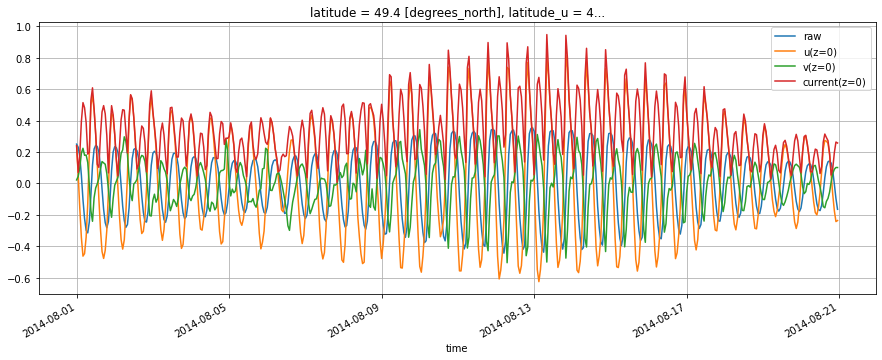

In [31]:
t = slice("2014-08-01", "2014-08-20")
_ds = ds.sel(time=t)

fig, ax = plt.subplots(1,1, figsize=(15,5))
(_ds["XE"]/10).plot(ax=ax, label="raw")
_ds["UZ_surf"].plot(ax=ax, label="u(z=0)")
_ds["VZ_surf"].plot(ax=ax, label="v(z=0)")
np.sqrt(_ds["UZ_surf"]**2+_ds["VZ_surf"]**2).plot(ax=ax, label="current(z=0)")
ax.legend()
ax.grid()

http://maree.info/25/calendrier?d=201511 

For August 2014:

Gives neap tide between the 5th and the 6th
Gives spring tide on the 13th


### neap-tides

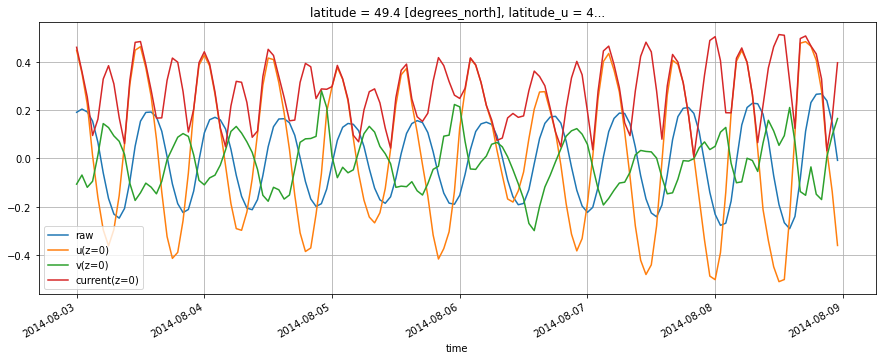

In [32]:
t = slice("2014-08-03", "2014-08-8")
_ds = ds.sel(time=t)

fig, ax = plt.subplots(1,1, figsize=(15,5))
(_ds["XE"]/10).plot(ax=ax, label="raw")
_ds["UZ_surf"].plot(ax=ax, label="u(z=0)")
_ds["VZ_surf"].plot(ax=ax, label="v(z=0)")
np.sqrt(_ds["UZ_surf"]**2+_ds["VZ_surf"]**2).plot(ax=ax, label="current(z=0)")
ax.legend()
ax.grid()

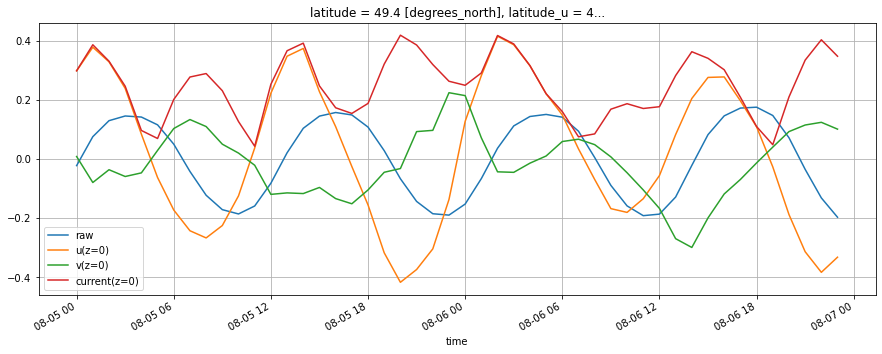

In [33]:
t = slice("2014-08-05", "2014-08-06")
_ds = ds.sel(time=t)

fig, ax = plt.subplots(1,1, figsize=(15,5))
(_ds["XE"]/10).plot(ax=ax, label="raw")
_ds["UZ_surf"].plot(ax=ax, label="u(z=0)")
_ds["VZ_surf"].plot(ax=ax, label="v(z=0)")
np.sqrt(_ds["UZ_surf"]**2+_ds["VZ_surf"]**2).plot(ax=ax, label="current(z=0)")
ax.legend()
ax.grid()

### spring tides

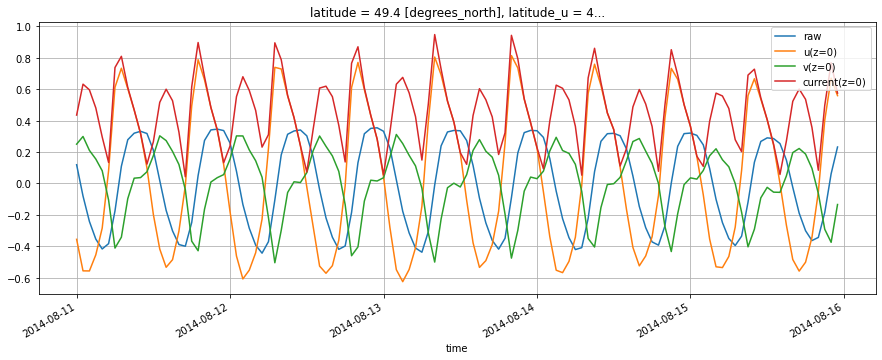

In [35]:
t = slice("2014-08-11", "2014-08-15")
_ds = ds.sel(time=t)

fig, ax = plt.subplots(1,1, figsize=(15,5))
(_ds["XE"]/10).plot(ax=ax, label="raw")
_ds["UZ_surf"].plot(ax=ax, label="u(z=0)")
_ds["VZ_surf"].plot(ax=ax, label="v(z=0)")
np.sqrt(_ds["UZ_surf"]**2+_ds["VZ_surf"]**2).plot(ax=ax, label="current(z=0)")
ax.legend()
ax.grid()

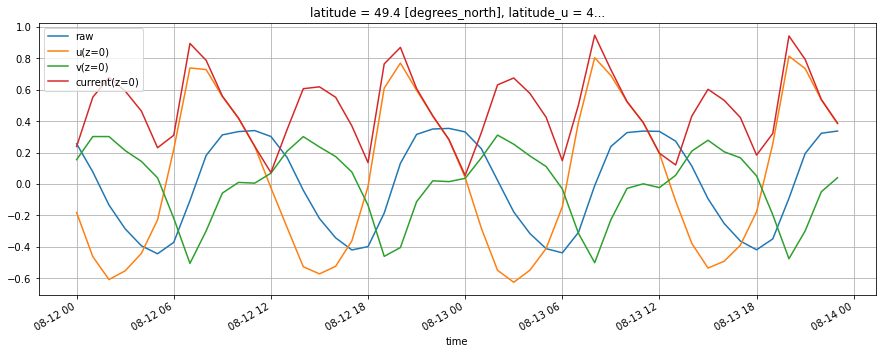

In [36]:
t = slice("2014-08-12", "2014-08-13")
_ds = ds.sel(time=t)

fig, ax = plt.subplots(1,1, figsize=(15,5))
(_ds["XE"]/10).plot(ax=ax, label="raw")
_ds["UZ_surf"].plot(ax=ax, label="u(z=0)")
_ds["VZ_surf"].plot(ax=ax, label="v(z=0)")
np.sqrt(_ds["UZ_surf"]**2+_ds["VZ_surf"]**2).plot(ax=ax, label="current(z=0)")
ax.legend()
ax.grid()

In [39]:
# about 45 min de décalage d'un jour à l'autre
T_M2 = 12.4206012 # hours
(T_M2 - 12) *24/T_M2 *60

48.76299611004338

There is an offset of about one hour between the simulation and [marée.info](http://maree.info/25?d=20140812)

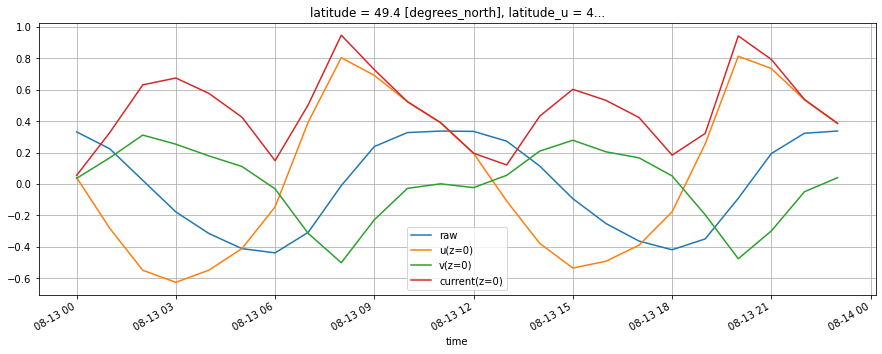

In [37]:
t ="2014-08-13"
_ds = ds.sel(time=t)

fig, ax = plt.subplots(1,1, figsize=(15,5))
(_ds["XE"]/10).plot(ax=ax, label="raw")
_ds["UZ_surf"].plot(ax=ax, label="u(z=0)")
_ds["VZ_surf"].plot(ax=ax, label="v(z=0)")
np.sqrt(_ds["UZ_surf"]**2+_ds["VZ_surf"]**2).plot(ax=ax, label="current(z=0)")
ax.legend()
ax.grid()

In [113]:
import pytide

# ---------------------------- tides ------------------------------------

def _harmonic_analysis(data, f=None, vu=None, wt=None):
    """ core method to be wrapped by harmonic_analysis
    """
    hanalysis = lambda data: wt.harmonic_analysis(data, f, vu)
    return np.apply_along_axis(hanalysis, -1, data)

def harmonic_analysis(da, constituents=[]):
    """ Distributed harmonic analysis
    
    Parameters
    ----------
    da: xr.Dataarray
    
    """
    #constituents = ["M2", "S2", "N2", "K2", "K1", "O1", "P1", "Q1", "S1", "M4"]
    wt = pytide.WaveTable(constituents) # not working on months like time series, need to restrict
    da = da.dropna("time")
    time = da.time.values.astype("datetime64[us]")
    f, vu = wt.compute_nodal_modulations(time)
    #return f, vu
    a = xr.apply_ufunc(_harmonic_analysis, da,
                       input_core_dims=[["time"],],
                       kwargs={"f": f, "vu": vu, "wt": wt},
                       output_core_dims=[["constituent"]],
                       vectorize=False,
                       dask="parallelized",
                       dask_gufunc_kwargs=dict(output_sizes=dict(constituent=f.shape[0])),
                       output_dtypes=[np.complex128]
                      )
    a = a.assign_coords(constituent=("constituent", wt.constituents()),
                        frequency=("constituent", wt.freq()*86400/2/np.pi),
                        frequency_rad=("constituent", wt.freq()), 
                       )
    return a.rename("amplitudes")

_ha = harmonic_analysis(ds["XE"], constituents=[])
_ha

<xarray.DataArray 'amplitudes' (constituent: 67)>
array([ 5.40652583e-02+4.54205604e-03j, -9.49458786e-03+3.48393300e-02j,
       -1.61863123e-02+9.11414090e-02j, -3.62654552e-02-6.76452962e-02j,
       -1.46582889e-01+1.01466590e+00j, -1.21821993e-01-4.79648164e-01j,
       -2.01739718e-02-3.85618609e-04j,  1.33084004e-01-2.62568547e+00j,
        3.61782245e-02+6.83788939e-02j, -5.61844045e-03-2.50004963e-03j,
        6.69376915e-01-6.59318353e-01j,  1.62394250e-01-1.77168975e-01j,
        1.69610534e-01+1.61544020e-01j, -2.11783560e-03+7.35216605e-03j,
        1.38779967e-02+6.01189895e-04j, -1.30228584e-02+2.32483451e-02j,
        2.49425558e-02-1.16154374e-02j, -1.00559490e-02-5.97496325e-03j,
        2.27043189e-02+4.15331415e-03j,  3.73860278e-01-2.17125439e-01j,
       -8.69070047e-03-3.78070912e-02j, -5.98334635e-03+8.33479353e-03j,
       -1.35530147e-04-2.08328522e-03j,  6.37404516e-03-2.76318905e-03j,
       -2.46514220e-03+4.27631893e-03j, -1.89245207e-01-1.86194459e-01j,
       -4.81670615e-02-3.55183040e-02j, -2.88819214e-03-1.61548401e-03j,
       -3.66442616e-03-9.25597645e-04j,  9.02161887e-04-5.31998734e-04j,
        3.31300040e-03-5.48849726e-04j, -1.10234971e-02-1.71322755e-03j,
       -1.52301362e-03-7.97616787e-03j, -7.50990731e-04+1.62524117e-03j,
       -3.23989148e-02-1.18558711e-01j,  7.19909997e-02+3.43849080e-02j,
       -1.06226488e-02+1.74096490e-01j,  2.27532282e-02+4.81913929e-03j,
        3.25996834e-03+3.67183678e-03j, -3.85236294e-02-9.94471462e-03j,
       -2.14298537e-02+7.80410038e-03j, -3.46301504e-01+2.01008267e-01j,
        1.45188677e-01+9.79965122e-02j, -3.80441665e-03+4.23599761e-02j,
       -4.88552124e-03+2.61703710e-02j, -4.62471816e-02-3.82362194e-02j,
       -4.25696206e-02-5.07684781e-02j,  5.00820306e-02-1.10912923e-01j,
        1.08835905e-02-2.44302961e-02j,  2.20363409e-03-3.49442250e-02j,
        2.90801597e-02-1.37105423e-02j,  1.34172269e-02-6.38896510e-03j,
       -1.82857970e-03+7.88512041e-03j, -3.43092628e-02+2.73120738e-02j,
        2.27841151e-03+1.33990597e-03j,  2.52350981e-01-9.83777317e-01j,
        1.10545896e-02+1.76746494e-02j, -6.70905123e-02-1.12917421e-01j,
       -1.85720944e-02+3.32012643e-02j, -4.25590554e-03+1.05999246e-01j,
        7.32367942e-03-1.07805586e-01j,  1.40671175e-02+4.14513091e-04j,
        6.44285756e-04-1.07960093e-03j,  3.44230436e-03+6.09691092e-03j,
        8.88479639e-03-2.31271962e-03j, -4.51383772e-03-1.41380492e-02j,
       -2.78674885e-02-7.11311764e-02j])
Coordinates:
    latitude       float64 49.4
    latitude_u     float64 49.4
    latitude_v     float64 49.4
    level          float32 -0.0125
    longitude      float64 -0.1988
    longitude_u    float64 -0.2021
    longitude_v    float64 -0.1988
    ni             float32 188.0
    ni_u           float32 187.5
    nj             float32 35.0
    nj_v           float32 34.5
  * constituent    (constituent) <U7 'O1' 'P1' 'K1' '2N2' ... 'MSf' 'Ssa' 'Sa'
    frequency      (constituent) float64 0.9295 0.9973 ... 0.005476 0.002738
    frequency_rad  (constituent) float64 6.76e-05 7.252e-05 ... 1.991e-07

In [114]:
ds[v+"_tide2"] = ut.predict_tides(ds.time, da=_ha, real=True, summed=True,)

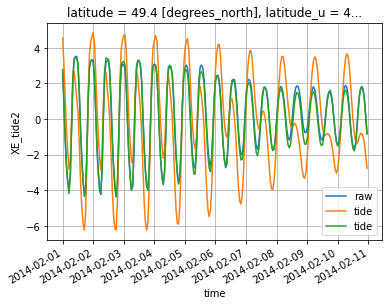

In [118]:
t = slice("2014-02-01", "2014-02-10")
_ds = ds.sel(time=t)

fig, ax = plt.subplots(1,1)
_ds["XE"].plot(ax=ax, label="raw")
_ds["XE_tide"].plot(ax=ax, label="tide")
_ds["XE_tide2"].plot(ax=ax, label="tide")
ax.legend()
ax.grid()

In [102]:
da = ds["XE"]
constituents=["M2","S2"]
data = da.values.astype(np.float64)

wt = pytide.WaveTable(constituents) # not working on months like time series, need to restrict
time = da.time.values.astype("datetime64[us]")
#time = da.time.values.astype("datetime64")
f, vu = wt.compute_nodal_modulations(time)

#hanalysis = lambda data: wt.harmonic_analysis(data, f, vu)
#har = np.apply_along_axis(hanalysis, -1, data)

wt.harmonic_analysis(data, f, vu)

array([nan+nanj, nan+nanj])

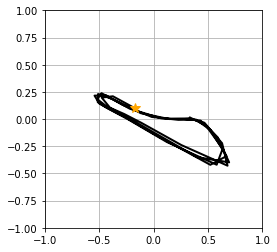

In [19]:
fig, ax = plt.subplots(1,1)

ax.plot(_ds.U, _ds.V, color="k", lw=2)
ax.plot(_ds.U.isel(time=0), _ds.V.isel(time=0), "*", color="orange", markersize=10)

lims = (-1., 1.)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.grid()
ax.set_aspect("equal")

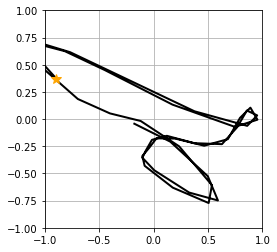

In [20]:
fig, ax = plt.subplots(1,1)

ax.plot(_ds.U_tide, _ds.V_tide, color="k", lw=2)
ax.plot(_ds.U_tide.isel(time=0), _ds.V_tide.isel(time=0), "*", color="orange", markersize=10)

lims = (-1., 1.)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.grid()
ax.set_aspect("equal")

---

In [ ]:
cluster.close()